In [16]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt

In [35]:
# Generate data
np.random.seed(2)
size = 100
mu = np.random.normal(0,1,size=size)
sigma = 1
X = np.random.normal(mu,sigma,size=size)

In [36]:
# Specify model
basic_model = pm.Model()
with basic_model:
    sigma = 1
    mu = pm.Normal('mu',mu=0,sd=sigma)
    X = pm.Normal('X',mu=mu,sd=sigma,observed=X)

In [49]:
# Draw samples from posterior
nr_of_samples = 100
with basic_model:
    trace = pm.sample(nr_of_samples,chains=1)
    samples_mu = trace['mu']
    samples_X = np.random.normal(samples_mu,1,size=nr_of_samples)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu]
100%|██████████| 600/600 [00:00<00:00, 2550.37it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


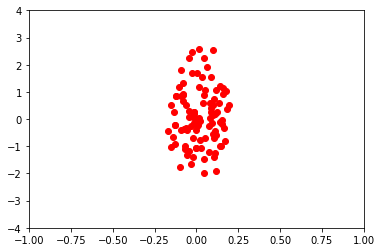

In [50]:
plt.plot(samples_mu, samples_X, 'ro')
plt.axis([-1, 1, -4, 4])
plt.show()
